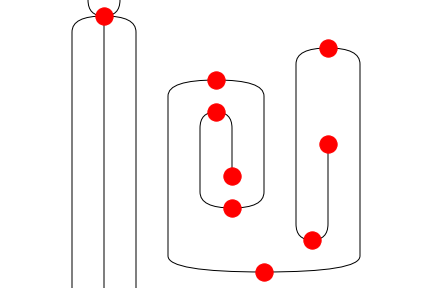

In [1]:
from discopy import *
from PIL import Image

diagram = Box('f', Ty('x', 'x'), Ty('x', 'x', 'x'))\
    @ monoidal.spiral(3)
rewrites = list(diagram.normalize())
diagram = rewrites[21]

params = dict(
    draw_types=False,
    draw_as_nodes=True,
    draw_box_labels=False,
    margins=(0.05, 0))

diagram.draw(**params, path='../docs/imgs/test-pixels2diagram.png')
img = Image.open('../docs/imgs/test-pixels2diagram.png')
img

In [2]:
import numpy as np

arr = np.array(img)
print("height, width, [red, blue, green, opacity]: {}".format(arr.shape))

height, width, [red, blue, green, opacity]: (288, 432, 4)


Found 9 boxes:


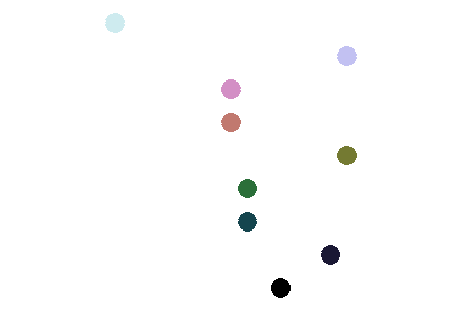

In [3]:
from skimage import measure
from matplotlib import pyplot as plt


threshold = 200
red = np.logical_and(arr[:, :, 0] > threshold,
                     arr[:, :, 1] < threshold,
                     arr[:, :, 2] < threshold)
box_pixels, n_boxes = measure.label(red, return_num=True)
print("Found {} boxes:".format(n_boxes))

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(-box_pixels, cmap='cubehelix')
plt.show()

Found 12 wires:


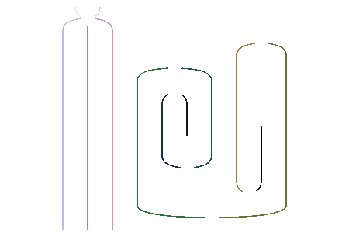

In [4]:
wire_pixels, n_wires = measure.label(arr[:, :, 0] < threshold, return_num=True)
print("Found {} wires:".format(n_wires))

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(-wire_pixels, cmap='cubehelix')
plt.show()

In [5]:
box_properties = measure.regionprops(box_pixels)
wire_properties = measure.regionprops(wire_pixels)

critical_heights = np.array(
    [0] + [box['centroid'][0] for box in box_properties] + [arr.shape[0]])

def find_start_and_endpoints(wire):
    start = np.argmin(np.abs(critical_heights - wire['coords'][0][0]))
    end = np.argmin(np.abs(critical_heights - wire['coords'][-1][0]))
    return (start, end)

print("Connectivity (wires to boxes [1, ..., 9] or boundary [0, 10]):")
wires_to_boxes = {i: find_start_and_endpoints(wire) for i, wire in enumerate(wire_properties)}
wires_to_boxes

Connectivity (wires to boxes [1, ..., 9] or boundary [0, 10]):


{0: (0, 1),
 1: (0, 1),
 2: (1, 10),
 3: (1, 10),
 4: (1, 10),
 5: (2, 8),
 6: (2, 9),
 7: (3, 9),
 8: (3, 7),
 9: (4, 7),
 10: (4, 6),
 11: (5, 8)}

In [6]:
print("Connectivity (boxes/boundary to wires):")
boxes_to_wires = {i: ([wire for wire, (_, end) in wires_to_boxes.items() if end == i],
                      [wire for wire, (start, _) in wires_to_boxes.items() if start == i])
                  for i, _ in enumerate(critical_heights)}
boxes_to_wires

Connectivity (boxes/boundary to wires):


{0: ([], [0, 1]),
 1: ([0, 1], [2, 3, 4]),
 2: ([], [5, 6]),
 3: ([], [7, 8]),
 4: ([], [9, 10]),
 5: ([], [11]),
 6: ([10], []),
 7: ([8, 9], []),
 8: ([5, 11], []),
 9: ([6, 7], []),
 10: ([2, 3, 4], [])}

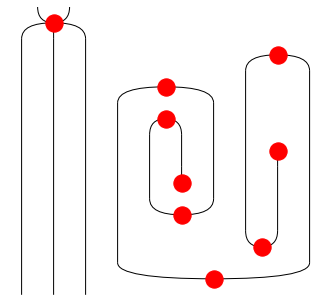

In [7]:
scan = boxes_to_wires[0][1]
result = Id(PRO(len(scan)))
for i, box_data in enumerate(box_properties):
    inputs, outputs = boxes_to_wires[i + 1]
    depth, width = map(int, box_data['centroid'])
    offset = len(set(wire_pixels[depth, :width]) - {wire + 1 for wire in inputs + outputs}) - 1
    box = Box('box_{}'.format(i), PRO(len(inputs)), PRO(len(outputs)))
    result = result\
        >> Id(PRO(offset)) @ box @ Id(PRO(len(scan) - len(inputs) - offset))
    scan = scan[:offset] + outputs + scan[offset + len(inputs):]
result.draw(**params)